In [1]:
# Copyright © [2023] [Bob]
# All rights reserved. This work is protected under copyright laws and international treaties. 
# Unauthorized reproduction, distribution, or modification of this work in any form or by any means, 
# without the prior written permission of the copyright holder, is strictly prohibited. 
# Violators will be prosecuted to the fullest extent of the law.

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

class BacktestAnalyzer:
    def __init__(self, start_date, end_date, trade_date, factor_path, ret_path, ud_path, group):
        self.start_date = start_date
        self.end_date = end_date
        self.trade_date = trade_date
        self.factor_path = factor_path
        self.ret_path = ret_path
        self.ud_path = ud_path
        self.group = group
        self.pnl = {}
        self.pro = {}
        self.ic = {}
        self.result = pd.DataFrame()

    def prepare_data(self):
        trade_date = pickle.load(open(self.trade_date, 'rb'))
        factor_files = sorted(os.listdir(self.factor_path))
        ret_files = sorted(os.listdir(self.ret_path))

        for file in tqdm(factor_files):
            date_tmp = file[:-4]
            next_date = trade_date[trade_date.index(date_tmp) + 1]

            if  file in ret_files and date_tmp >= self.start_date and date_tmp <= self.end_date:
                factor_tmp = pd.read_csv(f'{self.factor_path}/{file}', index_col=0, header=0)
                ret_tmp = pd.read_csv(f'{self.ret_path}/{next_date}.csv', index_col=0, header=0)
                ud_tmp = pd.read_csv(f'{self.ud_path}/{next_date}.csv', index_col=0, header=0)
                ud_tmp.set_index('code', inplace=True)

                merged=pd.concat([ret_tmp,ud_tmp[['zt','dt','paused']]],axis=1)
                index_tmp = factor_tmp.index.intersection(ret_tmp.index)

                res_fr = pd.concat([factor_tmp.loc[index_tmp, :], merged.loc[index_tmp, :]], axis=1)

                final = res_fr.loc[(res_fr['zt'] == 0) & (res_fr['dt'] == 0) & (res_fr['paused'] == 0), :].replace([np.inf, -np.inf], 0)

                self.calculate_metrics(final, date_tmp, factor_tmp)

    def calculate_metrics(self, final, date_tmp, factor_tmp):
        for col in factor_tmp.columns.to_list():
            if col not in self.pnl:
                self.pnl[col] = pd.DataFrame()
                self.pro[col] = pd.DataFrame()
                self.ic[col] = []
            if len(final[col].dropna().quantile(self.group).unique()) < 11:
                continue

            final[col + '_group'] = pd.qcut(final[col], 10, labels=False, duplicates='drop') + 1

            final['ret_1_pro'] = final['1vwap_pct'] - final['1vwap_pct'].mean()
            final['ret_1_pnl'] = final['1vwap_pct']

            result_agg = final.pivot_table(index=col + '_group', values=['ret_1_pnl', 'ret_1_pro'], aggfunc=np.mean)
                
                
            pnl_tmp = result_agg.T
            pnl_tmp = pnl_tmp.loc[pnl_tmp.index == 'ret_1_pnl']
            pnl_tmp['date'] = date_tmp
            pnl_tmp.set_index('date',inplace=True)
            pnl_tmp.columns.name = None
            pnl_tmp.index.name = None
            self.pnl[col] = pd.concat([self.pnl[col], pnl_tmp],axis = 0)

            pro_tmp = result_agg.T
            pro_tmp = pro_tmp.loc[pro_tmp.index == 'ret_1_pro']
            pro_tmp['date'] = date_tmp
            pro_tmp.set_index('date',inplace=True)
            pro_tmp.columns.name = None
            pro_tmp.index.name = None
            self.pro[col] = pd.concat([self.pro[col], pro_tmp],axis = 0)
            
            ic_tmp = final[col].corr(final['1vwap_pct'])
            self.ic[col].append(ic_tmp)

    def calculate_effectiveness(self):
        for factor in self.ic:
            ic = np.mean(self.ic[factor]).round(3)
            if(ic > 0):
                self.pro[factor].columns = self.pro[factor].columns[::-1]
                self.pnl[factor].columns = self.pnl[factor].columns[::-1]
            
            df = self.pro[factor]
            cumulative_returns = (1 + df).cumprod()
            dates = df.index
            plt.figure(figsize=(12, 6))
            for group in cumulative_returns.columns:
                plt.plot(dates, cumulative_returns[group], label=f'group_{group}')
            plt.title(factor + '_pro')
            plt.xlabel('date')
            plt.ylabel('pro')
            plt.legend()
            plt.grid(True)
            x_ticks_interval = 30
            plt.xticks(dates[::x_ticks_interval], rotation=45)           
            plt.show()
            
            self.pnl[factor]['hedge'] = self.pnl[factor][1] - self.pnl[factor][10]
            df = self.pnl[factor]
            # 计算累积收益
            cumulative_returns = (1 + df).cumprod()
            dates = df.index
            # 为每个组绘制累积收益
            plt.figure(figsize=(12, 6))
            for group in cumulative_returns.columns:
                plt.plot(dates, cumulative_returns[group], label=f'group_{group}')
            plt.title(factor + '_pnl')
            plt.xlabel('date')
            plt.ylabel('pnl')
            plt.legend()
            plt.grid(True)
            x_ticks_interval = 30
            plt.xticks(dates[::x_ticks_interval], rotation=45)
            
        
            
            icir = (np.mean(self.ic[factor]) / np.std(self.ic[factor])).round(3)
            
            long_ret = (np.mean(self.pnl[factor][1]) * 252).round(3)
            long_std = (np.std(self.pnl[factor][1]) * np.sqrt(252)).round(3)
            long_sr = (np.mean(self.pnl[factor][1]) * 252 / (np.std(self.pnl[factor][1]) * np.sqrt(252))).round(3)
            long_drawdown = ((cumulative_returns[1].cummax() - cumulative_returns[1]) / cumulative_returns[1].cummax()).round(3)
            long_maxdd = long_drawdown[long_drawdown.argmax()] * 100
            

            hedge_ret = (np.mean(self.pnl[factor]['hedge']) * 252).round(3)
            hedge_std = (np.std(self.pnl[factor]['hedge']) * np.sqrt(252)).round(3)
            hedge_sr = (np.mean(self.pnl[factor]['hedge']) * 252 / (np.std(self.pnl[factor]['hedge']) * np.sqrt(252))).round(3)
            hedge_drawdown = ((cumulative_returns['hedge'].cummax() - cumulative_returns['hedge']) / cumulative_returns['hedge'].cummax()).round(3)
            hedge_maxdd = hedge_drawdown[hedge_drawdown.argmax()] * 100
            
            new_row = {'factor_name': factor, 'ic:': ic, 'icir:': icir, '多头收益率:': long_ret, '多头波动率:': long_std, '多头sr:': long_sr, '多头最大回撤:': long_maxdd, 
                       '对冲收益率:': hedge_ret, '对冲波动率:': hedge_std, '对冲sr:': hedge_sr, '对冲最大回撤:': hedge_maxdd}
            self.result = pd.concat([self.result, pd.DataFrame([new_row])], ignore_index=True)




100%|██████████| 949/949 [01:07<00:00, 14.10it/s]


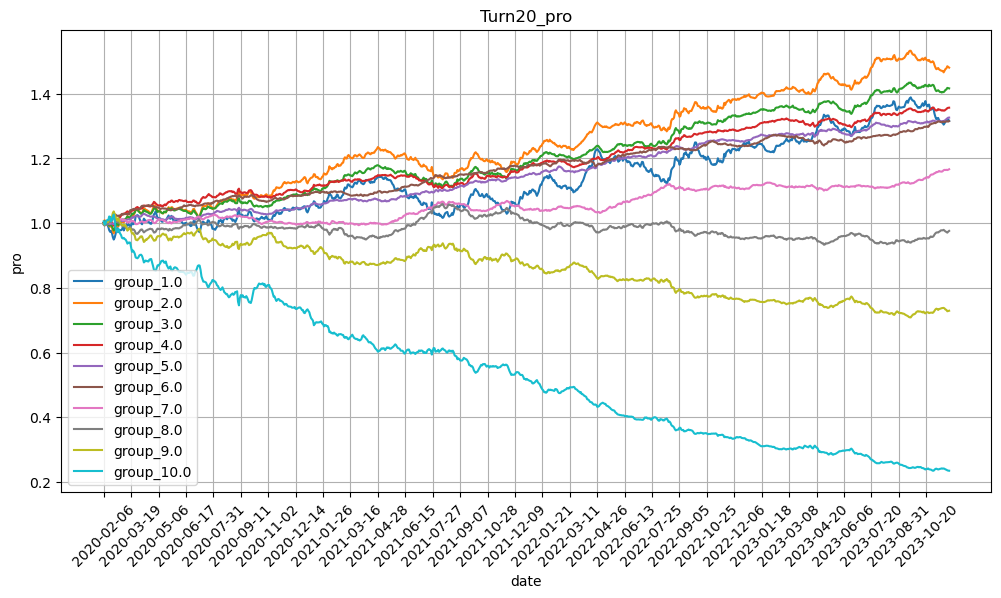

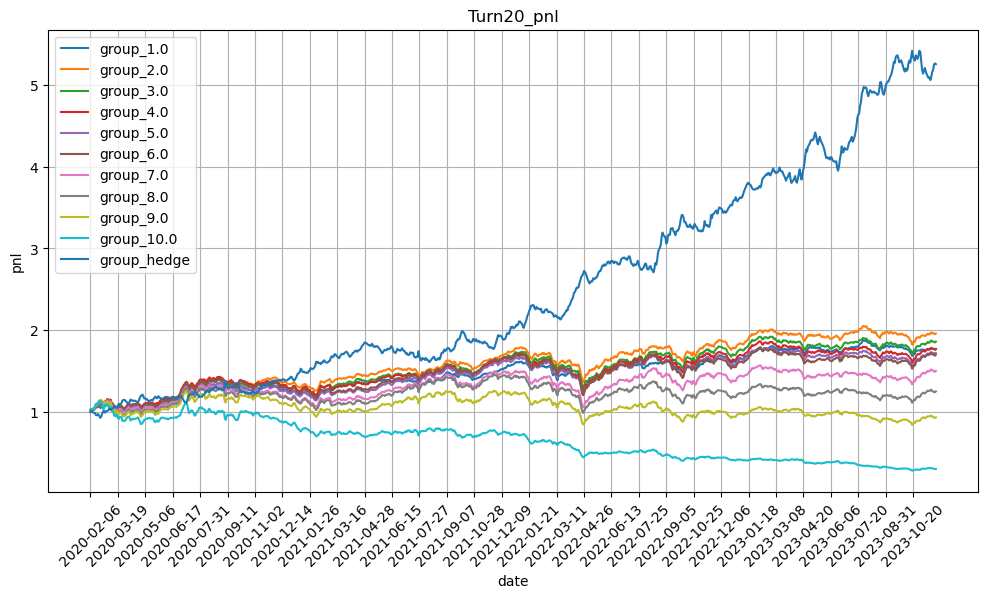

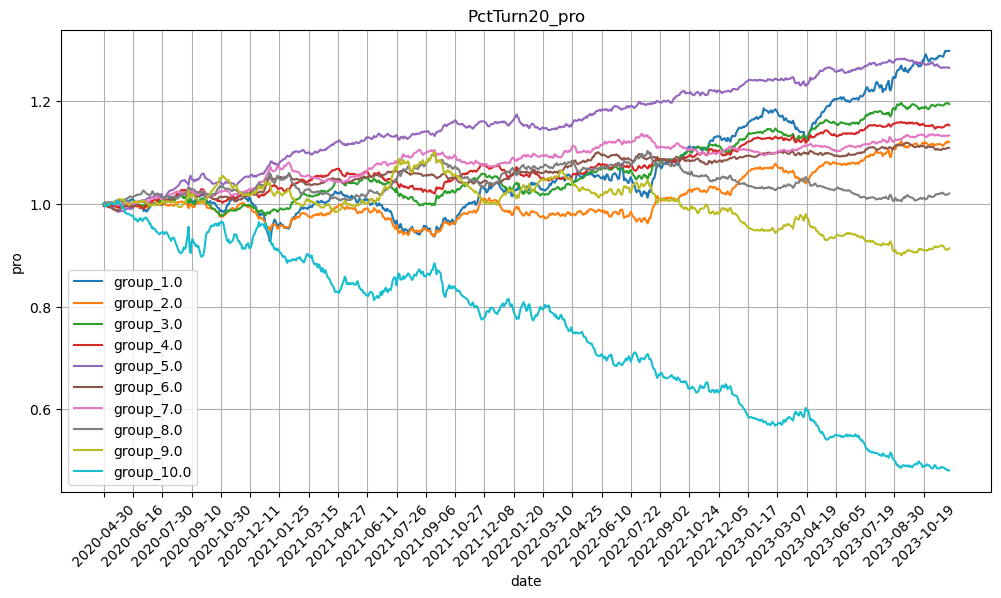

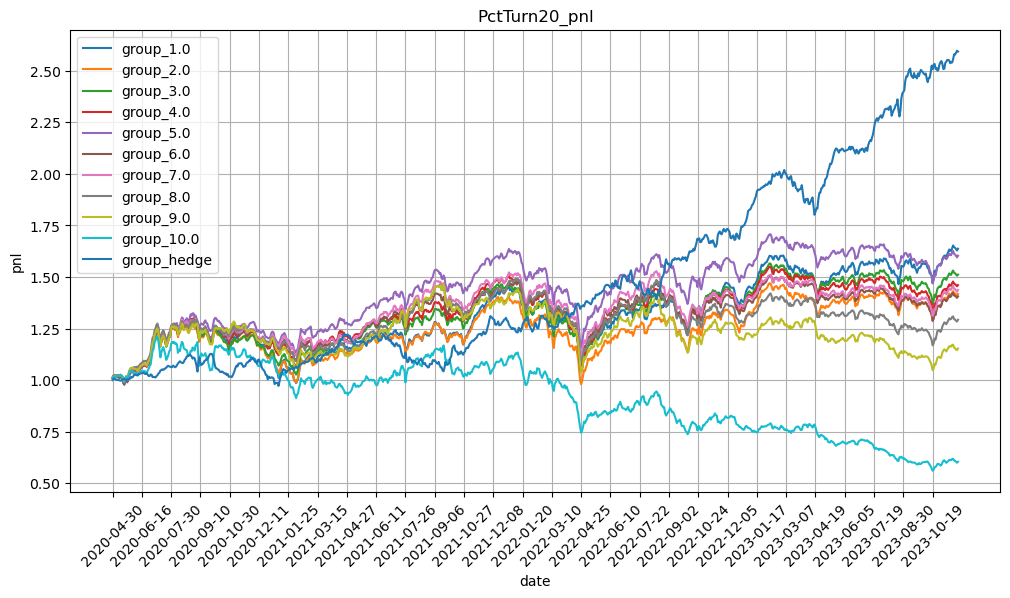

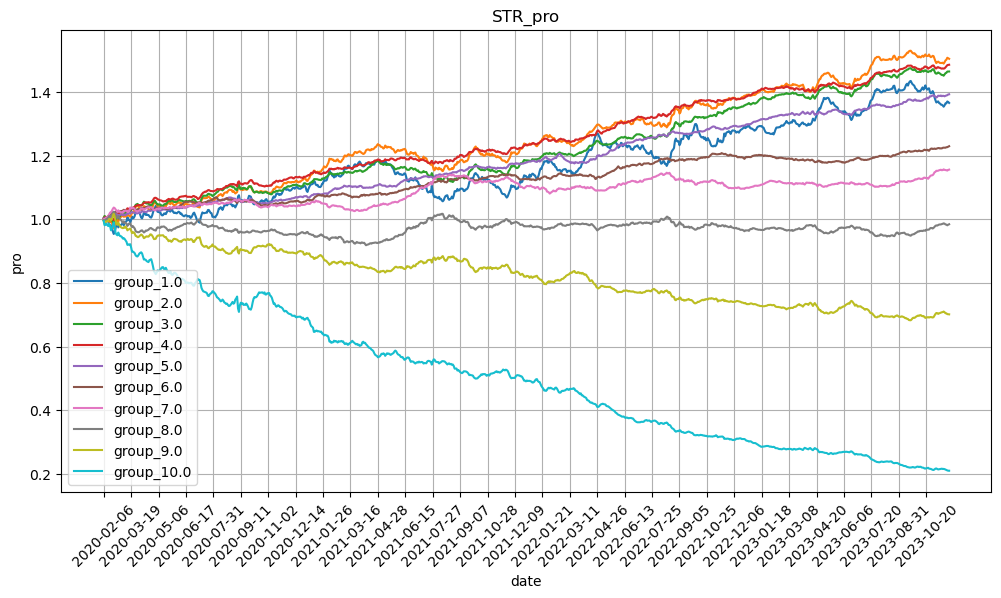

,factor_name,ic:,icir:,多头收益率:,多头波动率:,多头sr:,多头最大回撤:,对冲收益率:,对冲波动率:,对冲sr:,对冲最大回撤:
0,Turn20,-0.025,-0.216,0.163,0.128,1.273,20.1,0.467,0.172,2.717,13.0
1,PctTurn20,-0.016,-0.171,0.159,0.175,0.906,28.4,0.286,0.135,2.115,14.8
2,STR,-0.028,-0.273,0.173,0.131,1.315,20.4,0.508,0.157,3.235,11.6


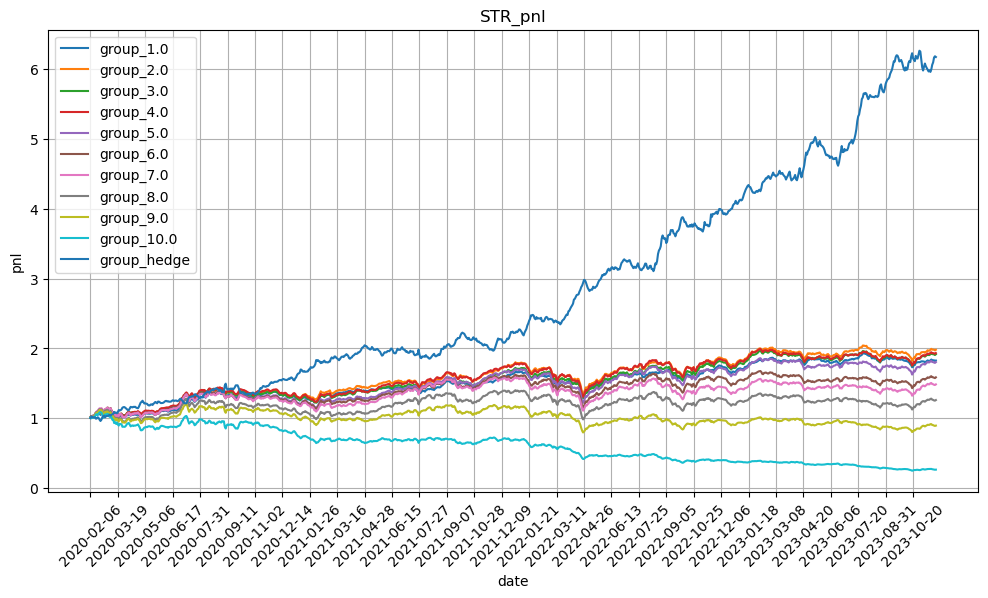

In [2]:
start_date = '2020-01-01'
end_date = '2023-11-25'
trade_date = '/Users/apple/Desktop/week1_1.1/data/date.pkl'
factor_path = '/Users/apple/Desktop/week1_1.1/week1_3/new_feature/LiangWen'
ret_path = '/Users/apple/Desktop/week1_1.1/data/data_ret'
ud_path = '/Users/apple/Desktop/week1_1.1/data/data_ud_new'
group = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

analyzer = BacktestAnalyzer(start_date, end_date, trade_date, factor_path, ret_path, ud_path, group)
analyzer.prepare_data()
analyzer.calculate_effectiveness()
analyzer.result

100%|██████████| 930/930 [00:43<00:00, 21.24it/s]


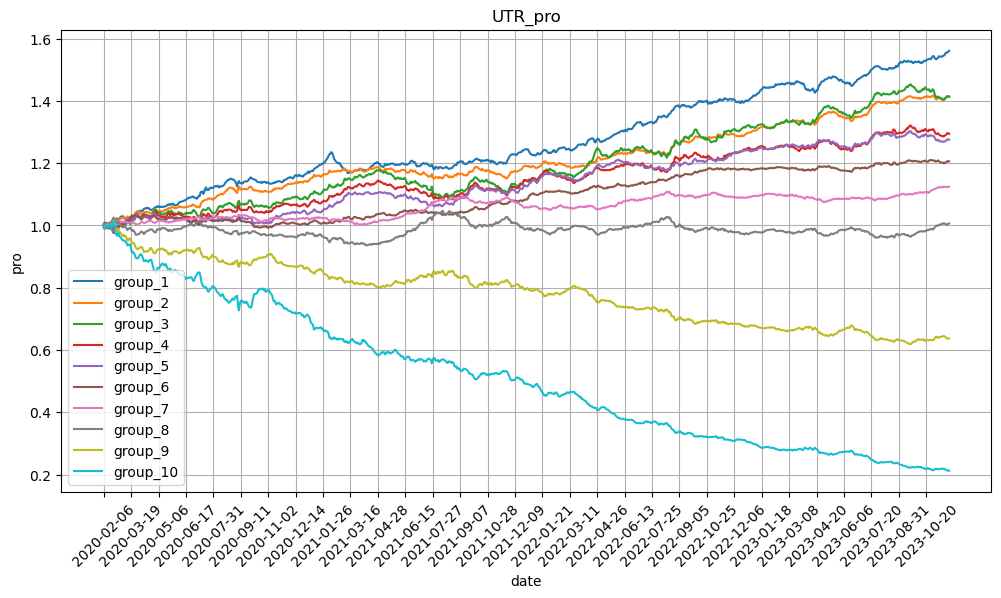

,factor_name,ic:,icir:,多头收益率:,多头波动率:,多头sr:,多头最大回撤:,对冲收益率:,对冲波动率:,对冲sr:,对冲最大回撤:
0,UTR,-0.023,-0.202,0.215,0.173,1.242,27.0,0.538,0.124,4.349,9.5


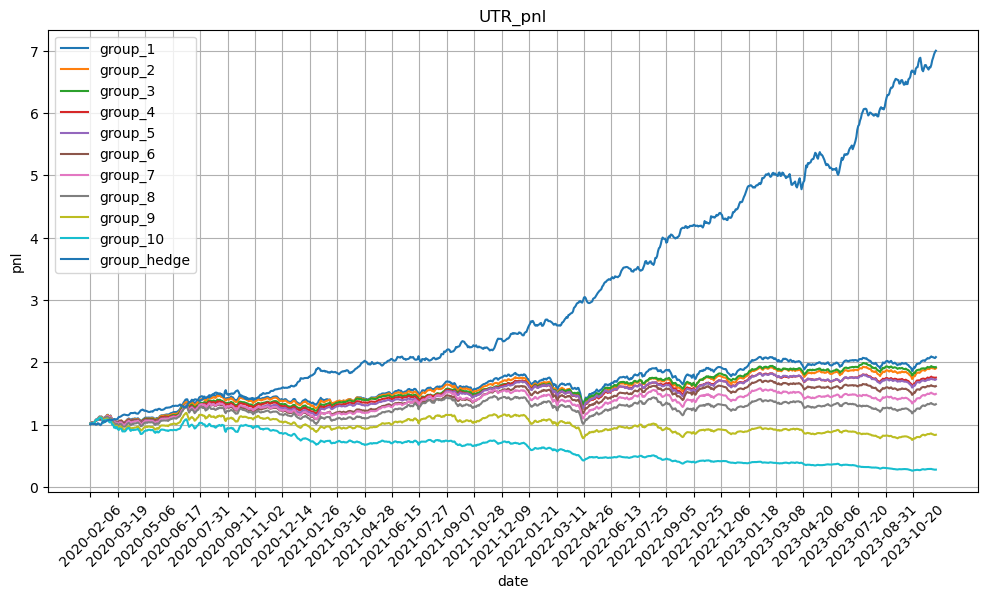

In [2]:
start_date = '2020-01-01'
end_date = '2023-11-25'
trade_date = '/Users/apple/quant_course/week1/week1_1/data/date.pkl'
factor_path = '/Users/apple/quant_course/week1/week1_3/factor/UTR'
ret_path = '/Users/apple/quant_course/week1/week1_1/data/data_ret'
ud_path = '/Users/apple/quant_course/week1/week1_1/data/data_ud_new'
group = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

analyzer = BacktestAnalyzer(start_date, end_date, trade_date, factor_path, ret_path, ud_path, group)
analyzer.prepare_data()
analyzer.calculate_effectiveness()
analyzer.result